---

# University of Liverpool

## COMP534 - Applied AI

---

This notebook is associated with Assignment 3. Use it to complete the assignment by following the instructions provided in each section. Each section includes a text cell outlining the requirements. For additional details, refer to Canvas.

Use this first cell to import the necessary libraries.

In [ ]:
# core Python libraries
import random
from collections import Counter

# data handling libraries
import numpy as np

# PyTorch libraries
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

# performace metric libraries
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.utils.class_weight import compute_class_weight

# visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt

# for reproducibility
import warnings
warnings.filterwarnings("ignore")

Use Google's GPUs where possible

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Define the random seed for the random and torch modules of our project

In [ ]:
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

# 1. **Data Management**


In this part, you need to:

1.  define your experimental protocol (such as k-fold, cross validation, etc);
2.	create the dataloader to load the data.



<h3>Loading the data</h3>

In [ ]:
def load_data(filepath):
  """
  Load the input data file in Python as string objects.
  Inputs: 1) filepath. \n
  Outputs: 1) sentences (list of lists). \n
           2) labels (list of lists).
  """
  sentences = []
  labels = []
  current_sentence = []
  current_labels = []

  # open the file with read permissions using UTF-8 encoding
  with open(filepath, "r") as f:
    for line in f:
      # remove external whitespaces
      line = line.strip()
      # separate each line into individual items - whitespace delimiter
      parts = line.split()

      # when a line has exactly two elements (word and label)
      if len(parts) == 2:
        # split line into two separate variables and append to relevant lists
        word, tag = parts
        current_sentence.append(word)
        current_labels.append(tag)

      # blank line check (end of sentence)
      elif len(parts) == 0:

        # checks for blank line at the start, or two blank lines in a row
        if current_sentence:
          # add current sentence / labels to ongoing list
          sentences.append(current_sentence)
          labels.append(current_labels)
          # reset current lists
          current_sentence = []
          current_labels = []

      # line maybe contains multiple words or labels
      else:
        print(f"Too many parts in {line}. This line will be skipped.")

  # if file doesn't end in a new line (i.e. not blank) add to sentences and labels
  if current_sentence:
    sentences.append(current_sentence)
    labels.append(current_labels)

  return sentences, labels


In [ ]:
# actually load the dataset with the appropriate file name
file_path = "assignment3-ner_dataset.txt"
sentences, labels = load_data(file_path)

# check details about the loaded file
print(f"Number of sentences: {len(sentences)}. {len(sentences) == 1696}.")
print(f"Words in first sentence: {sentences[0]}")
print(f"Labels in first sentence: {labels[0]}")

Number of sentences: 1696. True.
Words in first sentence: ['010', 'is', 'the', 'tenth', 'album', 'from', 'Japanese', 'Punk', 'Techno', 'band', 'The', 'Mad', 'Capsule', 'Markets', '.']
Labels in first sentence: ['I-MISC', 'O', 'O', 'O', 'O', 'O', 'I-MISC', 'O', 'O', 'O', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'O']


<h3>Data Preprocessing</h3>

Preprocessing assigns id numbers to words and labels and pads sentences to make them all the same length.

In [ ]:
def vocabulary(sentences, labels):
  """
  Convert sentences and labels to index values (including padding and unknowns).
  Inputs: 1) sentences (list of lists). \n
          2) labels (list of lists). \n
  Outputs: 1) word_indices, label_indices: dicts with indices as values.
           2) index_words, index_labels: dicts with words/labels as values.
  """
  # create set of unique words in the document
  word_set = set()

  for sentence in sentences:
    for word in sentence:
      word_set.add(word)

  # initialise word_indices dictionary with values for padding and unknown words
  # "unknown" words - appear in the test, but not training, dataset
  word_indices = {"<PAD>": 0, "<UNK>": 1}

  # add an index value for every word in training data
  # start at index=2 because 2 indices already exist in word_indices
  # sorting words alphabetically ensures the same word gets the same index every time
  for index, word in enumerate(sorted(word_set), start=2):
    word_indices[word] = index

  index_words = {}
  # index_words helps to decode indices later
  for word, index in word_indices.items():
    index_words[index] = word

  # now repeat above for labels
  # create set of unique labels in the document
  label_set = set()

  for sentence_labels in labels:
    for label in sentence_labels:
      label_set.add(label)

  # no "unknown" labels required
  label_indices = {"<PAD>": 0}

  # this time, start at index=1
  for index, label in enumerate(sorted(label_set), start=1):
    label_indices[label] = index

  index_labels = {}
  # index_labels helps to decode indices later
  for label, index in label_indices.items():
    index_labels[index] = label

  return word_indices, index_words, label_indices, index_labels


In [ ]:
# get indices from words and labels
word_indices, index_words, label_indices, index_labels = vocabulary(sentences, labels)

# hecks to ensure labels have been asigned correctly
print("<PAD>" in word_indices, "<UNK>" in word_indices)
print(f"Vocab size: {len(word_indices)}")
print(f"Entity tag set: {label_indices}")

print("------------------------------------------------------")

# check first sentence words and labels and total dataset size
print(f"First sentence sample: {sentences[:1]}")
print(f"First label sample: {labels[:1]}")
print(f"Total sentences: {len(sentences)}, Total labels: {len(labels)}")

True True
Vocab size: 8506
Entity tag set: {'<PAD>': 0, 'I-LOC': 1, 'I-MISC': 2, 'I-ORG': 3, 'I-PER': 4, 'O': 5}
------------------------------------------------------
First sentence sample: [['010', 'is', 'the', 'tenth', 'album', 'from', 'Japanese', 'Punk', 'Techno', 'band', 'The', 'Mad', 'Capsule', 'Markets', '.']]
First label sample: [['I-MISC', 'O', 'O', 'O', 'O', 'O', 'I-MISC', 'O', 'O', 'O', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'O']]
Total sentences: 1696, Total labels: 1696


<h3>Encoding and Padding our data</h3>

<b>Encoding:</b> Assigning ID numbers to words and labels in each sentence. This makes words and labels "readable" by the algorithm as they are now numerical values.

<b>Padding:</b> Not all sentences in the dataset are the same length, but the algorithm needs them to be. Padding adds 0s to the ends of sentences so that they match the length of the longest sentence in the dataset.

In [ ]:
def encode_and_pad(sentences, labels, word_indices, label_indices):
  """
  Encode and pad the sentences of the dataset.
  Inputs: 1) sentences, labels (lists of lists). \n
          2) word_indices, label_indices - indices which represent unique words
          and labels in the dataset. \n
  Outputs: 1) padded_sentences, padded_labels - encoded sentences and labels
           padded to the same length with 0s. \n
           2) attention_masks - ignores padding with a mask of 0.
  """
  # final, encoded sentences and labels
  encoded_sentences = []
  encoded_labels = []

  for sentence, label_seq in zip(sentences, labels):
    # make sentences into a list of indices
    word_ids = []
    for word in sentence:
      if word in word_indices:
        word_ids.append(word_indices[word])
      else:
        word_ids.append(word_indices["<UNK>"])

    # make label sequence for a sentence into a list of indices
    label_ids = []
    for label in label_seq:
      label_ids.append(label_indices[label])

    # convert word_ids and label_ids to tensors for PyTorch
    encoded_sentences.append(torch.tensor(word_ids))
    encoded_labels.append(torch.tensor(label_ids))

  # pad sequences, with batch size as the first dimension, and <PAD> as padding value
  padded_sentences = pad_sequence(encoded_sentences,
                                  batch_first=True,
                                  padding_value=word_indices['<PAD>'])
  padded_labels = pad_sequence(encoded_labels,
                                batch_first=True,
                                padding_value=label_indices['<PAD>'])

  # create attention masks (1 = actual words, 0 = padding)
  attention_masks = (padded_sentences != word_indices["<PAD>"])

  return padded_sentences, padded_labels, attention_masks

In [ ]:
# encode and pad the data we have imported
padded_sentences, padded_labels, attention_masks = encode_and_pad(sentences, labels, word_indices, label_indices)

# check details about the encoded and padded sentences and labels
print("Padded sentence shape:", padded_sentences.shape)
print("Padded label shape:", padded_labels.shape)
print("Attention mask shape:", attention_masks.shape)

Padded sentence shape: torch.Size([1696, 144])
Padded label shape: torch.Size([1696, 144])
Attention mask shape: torch.Size([1696, 144])


In [ ]:
print(padded_sentences)
print(padded_labels)
print(attention_masks)

tensor([[  51, 5969, 8001,  ...,    0,    0,    0],
        [3405, 3831, 7056,  ...,    0,    0,    0],
        [1679, 6322, 2169,  ...,    0,    0,    0],
        ...,
        [1597, 3287,   25,  ...,    0,    0,    0],
        [ 493, 6161, 6564,  ...,    0,    0,    0],
        [2661, 2473, 1744,  ...,    0,    0,    0]])
tensor([[2, 5, 5,  ..., 0, 0, 0],
        [5, 5, 5,  ..., 0, 0, 0],
        [5, 5, 4,  ..., 0, 0, 0],
        ...,
        [3, 3, 5,  ..., 0, 0, 0],
        [5, 5, 5,  ..., 0, 0, 0],
        [4, 4, 4,  ..., 0, 0, 0]])
tensor([[ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        ...,
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False]])


Create a class to handle information about the loaded dataset and store this information in an easily-accessible way:

In [ ]:
class NERDataset(torch.utils.data.Dataset):
  """
  Creates a data object that is compatible with PyTorch's DataLoader,
  for named entity recognition (NER).
  Stores retrievable information about words, labels and attention masks
  for the whole dataset.
  """

  def __init__(self, word_ids, label_ids, attention_masks):
    # intialise NERDataset object with word_ids, label_ids and attention_masks
    self.word_ids = word_ids
    self.label_ids = label_ids
    self.attention_masks = attention_masks

  def __len__(self):
    # return the number of unique words in the dataset
    return len(self.word_ids)

  def __getitem__(self, id):
    # return a dict of word_ids, labels and the attention_mask for a sentence
    return {
        "word_ids": self.word_ids[id],
        "label_ids": self.label_ids[id],
        "attention_mask": self.attention_masks[id]
    }

In [ ]:
# structure the dataset
dataset = NERDataset(padded_sentences, padded_labels, attention_masks)

# check details about dataset - number of sentences,
  # & padded sentence / labels and attention mask for the first sentence
print("Number of samples (sentences):", len(dataset))
print("First sentence data:", dataset[0])

Number of samples (sentences): 1696
First sentence data: {'word_ids': tensor([  51, 5969, 8001, 7983, 3831, 5501, 2058, 2904, 3378, 4068, 3394, 2348,
        1027, 2391,   37,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0, 

<h3>Building the DataLoader</h3>

The DataLoader object allows the data to be handled in a number of ways:
1. Batching multiple sentences together with a pre-defined batch size.
2. Shuffling batches in the training phase to prevent over-fitting.
3. Data is loaded in parallel to prevent "bottlenecks" and speed up data loading.
- Means that the GPU (if available) is not held back by the data not being loaded quickly.

In [ ]:
def create_dataloader(dataset, batch_size=50, shuffle=True):
  """
  Returns DataLoader object from dataset and batch_size inputs.
  """
  return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [ ]:
# define the batch size and intialise DataLoader object
batch_size = 64
train_dataloader = create_dataloader(dataset, batch_size=batch_size)

# inspect a batch
batch = next(iter(train_dataloader))
print("Batch word_ids shape:", batch["word_ids"].shape)
print("Batch labels shape:", batch["label_ids"].shape)
print("Batch attention_mask shape:", batch["attention_mask"].shape)

Batch word_ids shape: torch.Size([64, 144])
Batch labels shape: torch.Size([64, 144])
Batch attention_mask shape: torch.Size([64, 144])


<h3>Setting Up Stratified K-Fold</h3>

In [ ]:
def most_frequent_label(label_seq):
  """
  Find the most frequently-appearing label for a given sentence.
  """
  # how many times does each label appear in the sentence?
  label_counts = Counter(label_seq)

  # remove the "<PAD>" and "O" labels from label_counts
  for label in ["<PAD>", "O"]:
    label_counts.pop(label, None)

  # if there are any labels in label_counts, find the one which appears most often
  if label_counts:
    return max(label_counts, key=label_counts.get)
  # otherwise, state that there are no labels (i.e. "O")
  else:
    return "O"

def stratified_kfold_split(sentences, labels, k=5):
  """
  Split the dataset of sentences and labels into training and testing datasets.
  Then split training data into k equally-sized batches.
  """
  # add the most frequent label from each sentence to most_freq_labels
  most_freq_labels = []
  for label in labels:
    most_freq_labels.append(most_frequent_label(label))

  # establish stratified k fold with number of folds
  # shuffling will reorder the sentences before batching - avoids bias from order
  strat_k_fold = StratifiedKFold(n_splits=k, shuffle=True, random_state=SEED)

  # split the dataset into training and validation sets
  # include sentence, then labels for that sentence
  folds = []
  for train_id, val_id in strat_k_fold.split(sentences, most_freq_labels):
    train_data = ([sentences[i] for i in train_id], [labels[i] for i in train_id])
    val_data = ([sentences[i] for i in val_id], [labels[i] for i in val_id])
    folds.append((train_data, val_data))

  return folds

In [ ]:
# split the entire dataset into training and testing data using *built-in* sklearn function
# training:testing ratio = 85:15
sentences_train, sentences_test, labels_train, labels_test = train_test_split(
    sentences, labels, test_size=0.15, random_state=SEED,
    stratify=[most_frequent_label(label) for label in labels]
)

In [ ]:
# how many training and test sentences do we now have?
print(f"Number of training sentences: {len(sentences_train)}, {round(len(sentences_train)*100/len(sentences))}%")
print(f"Number of test sentences: {len(sentences_test)}, {round(len(sentences_test)*100/len(sentences))}%")

Number of training sentences: 1441, 85%
Number of test sentences: 255, 15%


In [ ]:
# initialise folds variable, with k folds of sentences and labels
folds = stratified_kfold_split(sentences_train, labels_train, k=5)

# check details about dataset - folds and size of training and validation
print(f"Total folds: {len(folds)}")
print(f"Train size (fold 0): {len(folds[0][0][0])}")
print(f"Val size (fold 0): {len(folds[0][1][0])}")

Total folds: 5
Train size (fold 0): 1152
Val size (fold 0): 289


In [ ]:
# unpack the folds variable into sentences and labels
# do this both for training and validation sets
train_sentences, train_labels = folds[0][0]
val_sentences, val_labels = folds[0][1]

print(f"Train samples: {len(train_sentences)}")
print(f"Val samples: {len(val_sentences)}")

Train samples: 1152
Val samples: 289


In [ ]:
def create_fold_dataloaders(fold_data, word_indices, label_indices, batch_size=64):
  """
  Creates a training and validation DataLoader object for a single fold of the dataset.
  Inputs: 1) fold_data - sentences and labels for a single fold. \n
          2) word_indices, label_indices - list of words and labels for each sentence. \n
          3) batch_size (default=64) - batch size for the fold. \n
  Outputs: 1) train_loader, val_loader - DataLoader object for training and validation
              data for one fold of the dataset.
  """
  ##### changed batch size here from 32 to 64 #####
  # unpack unpack fold_data into training and validation sets
  (train_sentences, train_labels), (val_sentences, val_labels) = fold_data

  # encode and pad the training dataset
  print(f"Encoding training data: {len(train_sentences)} sentences")
  train_inputs, train_targets, train_masks = encode_and_pad(
      train_sentences, train_labels, word_indices, label_indices
  )

  # encode and pad the validation dataset
  print(f"Encoding validation data: {len(val_sentences)} sentences")
  val_inputs, val_targets, val_masks = encode_and_pad(
      val_sentences, val_labels, word_indices, label_indices
  )

  # create training and validation datasets with NERDataset class structure
  train_dataset = NERDataset(train_inputs, train_targets, train_masks)
  val_dataset = NERDataset(val_inputs, val_targets, val_masks)

  # create training and validation DataLoader objects
  train_loader = create_dataloader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = create_dataloader(val_dataset, batch_size=batch_size, shuffle=False)

  # print batch info
  print(f"Train batches: {len(train_loader)}")
  print(f"Val batches: {len(val_loader)}")

  return train_loader, val_loader

<h3>Splitting all k-folds into training and validation sets</h3>

In [ ]:
# create train_loader and val_loader with our data
train_loader, val_loader = create_fold_dataloaders(folds[0], word_indices, label_indices)

# check a batch
sample = next(iter(train_loader))
print("Train batch shape:", sample["word_ids"].shape)

Encoding training data: 1152 sentences
Encoding validation data: 289 sentences
Train batches: 18
Val batches: 5
Train batch shape: torch.Size([64, 144])


---

# 2. **Neural Networks**

Here, you need to:

1.	create a Recurrent Neural Network (RNN) (such as RNN, GRU, LSTM) to tackle the problem;
2.	create a Transformer Network to tackle the problem;
3.	define the necessary components to train the networks (that is, loss function, optimizers, etc);
4.	train the models;
5.	for all training procedures, separately plot the loss and accuracy with respect to the epoch/iteration.

### Model 1 - Training the BiLSTM Model

Why is BiLSTM better than LSTM?
- Know the underlying functionality
- https://medium.com/@souro400.nath/why-is-bilstm-better-than-lstm-a7eb0090c1e4

In [ ]:
class BiLSTMTagger(nn.Module):
  def __init__(self, vocab_size, tagset_size, embedding_dim=100, hidden_dim=128, pad_idx=0):
    super(BiLSTMTagger, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
    self.bilstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
    self.fc = nn.Linear(hidden_dim * 2, tagset_size)

  def forward(self, input_ids, attention_mask=None):
    embedded = self.embedding(input_ids)  # (batch, seq_len, embed_dim)
    self.dropout = nn.Dropout(0.3) # dropout
    lstm_out, _ = self.bilstm(embedded)   # (batch, seq_len, 2*hidden_dim)
    lstm_out = self.dropout(lstm_out) # dropout
    logits = self.fc(lstm_out)            # (batch, seq_len, tagset_size)
    return logits

In [ ]:
class EarlyStopping:
  def __init__(self, patience=2):
    self.patience = patience
    self.counter = 0
    self.best_val_loss = float("inf")
    self.early_stop = False

  def step(self, val_loss):
    if val_loss < self.best_val_loss:
      self.best_val_loss = val_loss
      self.counter = 0
    else:
      self.counter += 1
      if self.counter >= self.patience:
        self.early_stop = True

In [ ]:
# initialise the BiLSTM model with some initial hyperparameters
model = BiLSTMTagger(
  vocab_size=len(word_indices),
  tagset_size=len(label_indices),
  embedding_dim=100,
  hidden_dim=128,
  pad_idx=word_indices["<PAD>"]
)

<h3>Dealing with dataset imbalance</h3>

The dataset we have been given is imbalanced. It contains many more words for the O class than for any other.

We need to manipulate the data in some way to handle this issue.

Our goal:
- Downweight the O class.
- total / count['O'] becomes small → lower weight of the 'O' Class.
- What this would ensure is that the model pays less penalty when it misclassifies O, and more for rare classes.

In [ ]:
# Count label frequencies (excluding padding)
all_labels_flat = [tag for label_seq in labels for tag in label_seq if tag != '<PAD>']
label_counts = Counter(all_labels_flat)

# Create weights: inverse frequency
total = sum(label_counts.values())
class_weights = []
for tag in sorted(label_indices.keys(), key=lambda x: label_indices[x]):
  if tag == "<PAD>":
    class_weights.append(0.0)
  else:
    class_weights.append(total / label_counts.get(tag, 1))

# Normalize and convert to tensor
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# Weighted loss
loss_fn = nn.CrossEntropyLoss(weight=weights_tensor, ignore_index=label_indices["<PAD>"])

# # Downweighting the 'O' class
# weights = torch.ones(len(label_indices))
# weights[label_indices['O']] = 0.1
# loss_fn = nn.CrossEntropyLoss(weight=weights.to(device), ignore_index=label_indices["<PAD>"])

<h3>Defining the optimiser (and the scheduler)</h3>

The purpose of the scheduler is to reduce the learning rate of our model(s) every n steps. Here, LR is being cut by 0.5 every 3 epochs.

This helps to fine-tune the weights of our model(s) as they converge.

**NB: We ended up not using the scheduler because it didn't work very well**

In [ ]:
# define the optimiser (and scheduler; not used)
optimiser = torch.optim.Adam(model.parameters(), lr=0.0005)
# scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=3, gamma=0.5) # A learning rate scheduler

<h3>BiLSTM Training and Validation Loop</h3>

In [ ]:
def train_one_epoch(model, dataloader, optimiser, loss_fn, device):
  """
  Train the model for one epoch with the chosen hyperparameters and optimiser.
  Inputs: 1) model - model class. \n
          2) dataloader - the DataLoader object. \n
          3) optimiser - the optimiser with defined hyperparameters. \n
          4) loss_fn - loss function (e.g. Adam). \n
          5) device - cpu or gpu. \n
  Outputs: 1) average loss of the one epoch.
  """
  # set model to training mode and set running loss to 0
  model.train()
  total_loss = 0

  # loop through each batch
  for batch in dataloader:
    word_ids = batch["word_ids"].to(device)
    label_ids = batch["label_ids"].to(device)
    mask = batch["attention_mask"].to(device)

    # reset optimiser gradient
    optimiser.zero_grad()
    outputs = model(word_ids)  # (batch, seq_len, num_tags)

    # reshape for loss: (batch * seq_len, num_tags) vs (batch * seq_len)
    loss = loss_fn(outputs.view(-1, outputs.shape[-1]), label_ids.view(-1))
    loss.backward()
    optimiser.step()

    # update the running loss
    total_loss += loss.item()

  return total_loss / len(dataloader)

In [ ]:
def evaluate(model, dataloader, loss_fn, device):
  """
  Return the average loss of given model for a single epoch.
  Inputs: 1) model - model class. \n
          2) dataloader - the DataLoader object. \n
          3) loss_fn - e.g. CrossEntropyLoss. \n
          4) device - cpu or gpu. \n
  Outputs: 1) average loss of one epoch.
  """
  # set the model to evaluation mode
  model.eval()
  total_loss = 0

  # loop through each batch of the dataset
  with torch.no_grad():
    for batch in dataloader:
      word_ids = batch["word_ids"].to(device)
      label_ids = batch["label_ids"].to(device)
      mask = batch["attention_mask"].to(device)

      # calculate running loss, then average loss per epoch
      outputs = model(word_ids)
      loss = loss_fn(outputs.view(-1, outputs.shape[-1]), label_ids.view(-1))
      total_loss += loss.item()

  return total_loss / len(dataloader)

In [ ]:
def train_model(model, train_loader, val_loader, optimiser, loss_fn, device,
                                    num_epochs=10):
  """
  Train the chosen model (e.g. RNN or LSTM) with the chosen loss function and optimiser.
  Function includes early stopping after a user-determined number of iterations.
  Inputs: see function definition.
  Outputs: list of losses for each epoch from the:
           1) training dataset. \n
           2) validation dataset. \n
  """
  # loss values for training and validation datasets and best loss so far
  train_losses = []
  val_losses = []

  # define the early stopping criterion
  patience = 3
  stopper = EarlyStopping(patience)

  for epoch in range(num_epochs):
    # train the model for one epoch
    # determine the loss for the training and validation datasets
    train_loss = train_one_epoch(model, train_loader, optimiser, loss_fn, device)
    val_loss = evaluate(model, val_loader, loss_fn, device)

    # append loss values to relevant lists
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # print loss after each epoch
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # early stopping and scheduler implementation
    # scheduler called only once per epoch
    stopper.step(val_loss)

    if stopper.early_stop:
      # when loss does not decrease for {patience} iterations in a row, stop.
      print(f"Loss has not decreased for {patience} consecutive iterations. \n Early stopping triggered.")
      break

  return train_losses, val_losses

<h3>Hyperparameter Optimisation</h3>

For this project, we have chosen to use grid search as our optimisation procedure. It is a slower and more computationally-heavy approach than random search, but we want to find the best possible hyperparameters.

In [ ]:
# grid that our optimisation will iterate through to find the best hyperparams
  # embedding_dim: number of dimensions that each word is defined as
  # hidden_dim: number of features of hidden state. With BiLSTM, this value is x2.
  # lr: learning rate of the optimiser
hyperparam_grid = [
  {"embedding_dim": 50, "hidden_dim": 64, "lr": 0.0005},
  {"embedding_dim": 50, "hidden_dim": 128, "lr": 0.0005},
  {"embedding_dim": 50, "hidden_dim": 256, "lr": 0.0005},
  {"embedding_dim": 100, "hidden_dim": 64, "lr": 0.0005},
  {"embedding_dim": 100, "hidden_dim": 128, "lr": 0.0005},
  {"embedding_dim": 100, "hidden_dim": 256, "lr": 0.0005},
  {"embedding_dim": 200, "hidden_dim": 64, "lr": 0.0005},
  {"embedding_dim": 200, "hidden_dim": 128, "lr": 0.0005},
  {"embedding_dim": 200, "hidden_dim": 256, "lr": 0.0005},
  {"embedding_dim": 300, "hidden_dim": 64, "lr": 0.0005},
  {"embedding_dim": 300, "hidden_dim": 128, "lr": 0.0005},
  {"embedding_dim": 300, "hidden_dim": 256, "lr": 0.0005},
]

# best hyperparameters
results = []

# try every combination of hyperparameters
for hyperparam_set in hyperparam_grid:
  print(f"Testing config: {hyperparam_set}")

  # initialise the model with one combination of hyperparameters
  model = BiLSTMTagger(
    vocab_size=len(word_indices),
    tagset_size=len(label_indices),
    embedding_dim=hyperparam_set["embedding_dim"],
    hidden_dim=hyperparam_set["hidden_dim"],
    pad_idx=word_indices["<PAD>"]
  ).to(device)

  # define the optimiser and learning rate
  optimiser = torch.optim.Adam(model.parameters(), lr=0.0005)

  # train the BiLSTM model with the chosen hyperparameters
  train_losses, val_losses = train_model(
    model, train_loader, val_loader,
    optimiser, loss_fn, device,
    num_epochs=10,
  )

  # to the results list, add a dictionary containing list of hyperparameters
  # and the most recently-achieved loss
  results.append({
    "hyperparameters": hyperparam_set,
    "final_train_loss": train_losses[-1] if train_losses else None,
    "final_val_loss": val_losses[-1] if val_losses else None
  })

Testing config: {'embedding_dim': 50, 'hidden_dim': 64, 'lr': 0.0005}
Epoch 1/10 | Train Loss: 1.7648 | Val Loss: 1.7350
Epoch 2/10 | Train Loss: 1.7114 | Val Loss: 1.6846
Epoch 3/10 | Train Loss: 1.6493 | Val Loss: 1.6195


KeyboardInterrupt: 

In [ ]:
# find config with smallest training loss
best_train_result = min(results, key=lambda x: x["final_train_loss"] if x["final_train_loss"] is not None else float("inf"))

print("\nBest hyperparameters based on training loss:")
print(f"Hyperparameters: {best_train_result['hyperparameters']}")
print(f"Final Training Loss: {best_train_result['final_train_loss']:.4f}")

# automatically determine the best hyperparameters from the grid search
best_hyperparameters = best_train_result["hyperparameters"]

<h3>Training the BiLSTM model!</h3>

In [ ]:
# define the BiLSTM model with the optimal hyperparameters from above
model = BiLSTMTagger(
    vocab_size=len(word_indices),
    tagset_size=len(label_indices),
    embedding_dim=best_hyperparameters["embedding_dim"],
    hidden_dim=best_hyperparameters["hidden_dim"],
    pad_idx=word_indices["<PAD>"]
  ).to(device)

# update the optimiser to have the best hyperparameters and learning rate
optimiser = torch.optim.Adam(model.parameters(), lr=best_hyperparameters["lr"])

In [ ]:
# train the model using the updated, optimal hyperparameters and optimiser
train_losses, val_losses = train_model(
    model, train_loader, val_loader,
    optimiser, loss_fn, device,
    num_epochs=10
)

<h3>Plotting the loss curves</h3>

In [ ]:
def plot_loss_curves(train_losses, val_losses, model):
  """
  Plot the loss per epoch data for training anf validation datasets.
  Inputs: 1) train_losses, val_losses - list of loss values for training and
  validation datasets. \n
          2) model - name of model (string representation). \n
  Outputs: 1) None returned - graph plot.
  """
  plt.figure(figsize=(8, 5))
  plt.plot(train_losses, label="Training Loss")
  plt.plot(val_losses, label="Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title(f"Loss per Epoch for the {model} Model")
  plt.legend()
  plt.grid(True)
  plt.show()

In [ ]:
# plot the loss graph for training validation datasets
plot_loss_curves(train_losses, val_losses, "BiLSTM")

In [ ]:
def print_hyperparameters(model, optimiser, dataloader):
  """
  Display all the hyperparameters applied in our model.
  Inputs: 1) model - model class. \n
          2) optimiser - optimiser (e.g. Adam) with optimal hyperparameters. \n
          3) dataloader - DataLoader object for the dataset. \n
  Outputs: 1) None returned - prints hyperparameters.
  """
  print("📌 Hyperparameters Used:")
  print(f"Embedding dim      : {model.embedding.embedding_dim}")
  print(f"Hidden dim         : {model.bilstm.hidden_size}")
  print(f"Dropout rate       : {model.dropout.p}")
  print(f"Learning rate      : {optimiser.param_groups[0]['lr']}")
  print(f"Batch size         : {dataloader.batch_size}")

<h3>Model Evaluation and Confusion Matrix</h3>

In [ ]:
def get_predictions(model, dataloader, device):
  """
  Make predictions about which label belongs to each word.
  Inputs: 1) model - model class. \n
          2) dataloader - DataLoader object for the dataset. \n
          3) device - cpu or gpu
  Outputs: 1) all_preds - predictions made by the model. \n
           2) all_labels - true labels for each word in the dataset.
  """
  # set the model to evaluation mode
  model.eval()
  # initiate lists to store predicted and true labels
  all_preds, all_labels = [], []

  # loop through each batch in the dataset
  with torch.no_grad():
    for batch in dataloader:
      word_ids = batch["word_ids"].to(device)
      label_ids = batch["label_ids"].to(device)
      mask = batch["attention_mask"].to(device)

      # retrieve the outputs from the model and make label predictions
      outputs = model(word_ids)
      predictions = torch.argmax(outputs, dim=-1)

      # flatten and filter out padding
      for pred_seq, label_seq, attn in zip(predictions, label_ids, mask):
        for p, l, m in zip(pred_seq, label_seq, attn):
          if m == 1:  # not padding
            all_preds.append(p.item())
            all_labels.append(l.item())

  return all_preds, all_labels

In [ ]:
def evaluate_metrics(preds, labels, index_labels):
  """
  Generate a confusion matrix based on labels and predictions from the model.
  Inputs: 1) preds - list of the model's predictions. \n
          2) labels - list of true labels for each word of the dataset. \n
          3) index_labels -
  """
  # convert indices back to tag strings
  tag_preds = [index_labels[i] for i in preds]
  tag_labels = [index_labels[i] for i in labels]

  # print the the stats for the model predictions
  print("\nClassification Report:\n")
  print(classification_report(tag_labels, tag_preds, labels=list(set(tag_labels)), digits=4))

  # initialise the confusion matrix
  cm = confusion_matrix(tag_labels, tag_preds, labels=list(label_indices.keys())[1:])  # skip <PAD>
  return cm

In [ ]:
preds, true_labels = get_predictions(model, val_loader, device)
conf_matrix = evaluate_metrics(preds, true_labels, index_labels)

In [ ]:
def plot_confusion_matrix(cm, labels):
  """
  Generate and plot the confusion matrix for the dataset.
  Inputs: 1) cm - confusion_matrix. \n
          2) labels - list of labels (e.g. "I-LOC", "O" etc.) from the dataset.\n
  Outputs: 1) None returned - confusion matrix plot.
  """
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
              xticklabels=labels, yticklabels=labels)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title("Confusion Matrix")
  plt.tight_layout()
  plt.show()

In [ ]:
labels = list(label_indices.keys())[1:]  # skip <PAD>
plot_confusion_matrix(conf_matrix, labels)

<

In [ ]:
print_hyperparameters(model, optimiser, train_loader)

### Model 2 - Transformer Model

<h3>Final configuration after grid search</h3>

In [ ]:
# these are the tuned hyperparameters used to build and train the model
final_config = {
    'd_model': 256,         # size of token embeddings
    'nhead': 4,             # number of attention heads
    'dropout': 0.3,         # dropout rate for regularization
    'lr': 0.001,            # learning rate for the optimizer
    'num_layers': 4,        # number of transformer encoder layers
    'epochs': 15,           # number of training epochs
    'max_len': 512,         # maximum sequence length for position encoding
    'weight_decay': 1e-5    # weight decay (L2 regularization)
}

<h3>Model definition</h3>

In [ ]:
class FinalTransformerNER(nn.Module):
    """
    Transformer-based Named Entity Recognition model.
    Uses token embeddings, learned positional encodings,
    and a multi-layer transformer encoder to predict entity tags for each token.
    """
    def __init__(self, vocab_size, num_tags, cfg):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, cfg["d_model"], padding_idx=word_indices["<PAD>"])
        self.position = nn.Embedding(cfg["max_len"], cfg["d_model"])

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=cfg["d_model"],
            nhead=cfg["nhead"],
            dim_feedforward=512,
            dropout=cfg["dropout"],
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=cfg["num_layers"])
        self.norm = nn.LayerNorm(cfg["d_model"])
        self.dropout = nn.Dropout(cfg["dropout"])
        self.fc = nn.Linear(cfg["d_model"], num_tags)

    def forward(self, x, mask):
        """
        Forward pass of the model.
        x: input word IDs [batch_size, seq_len]
        mask: attention mask (True for real tokens, False for padding)
        """
        pos = torch.arange(0, x.size(1), device=x.device).unsqueeze(0).expand_as(x)
        x = self.embedding(x) + self.position(pos)  # Add positional encoding
        x = self.transformer(x, src_key_padding_mask=~mask)  # Apply attention
        x = self.norm(x)
        x = self.dropout(x)
        return self.fc(x)

<h3>Class weights</h3>

In [ ]:
# to handle class imbalance in NER (many 'O', fewer named entities)
true_labels = []
for batch in train_loader:
    for seq in batch["label_ids"]:
        true_labels.extend([int(x) for x in seq if x != -100])  # Exclude padding

all_classes = np.unique(true_labels)
weights = compute_class_weight(class_weight='balanced', classes=all_classes, y=true_labels)
class_weights = torch.ones(len(label_indices))
for i, cls in enumerate(all_classes):
    class_weights[cls] = weights[i]
class_weights = class_weights.to(device)

<h3>Model initialisation</h3>

In [ ]:
model = FinalTransformerNER(len(word_indices), len(label_indices), final_config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=final_config["lr"], weight_decay=final_config["weight_decay"])
criterion = nn.CrossEntropyLoss(ignore_index=-100, weight=class_weights)

<h3>Training Loop</h3>

In [ ]:
losses = []

for epoch in range(final_config["epochs"]):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs = batch["word_ids"].to(device)
        labels = batch["label_ids"].to(device)
        mask = batch["attention_mask"].to(device)

        outputs = model(inputs, mask)
        loss = criterion(outputs.view(-1, outputs.size(-1)), labels.view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    losses.append(total_loss)
    print(f"[Final Model] Epoch {epoch+1}/{final_config['epochs']} - Loss: {total_loss:.4f}")

[Final Model] Epoch 1/15 - Loss: 32.4868
[Final Model] Epoch 2/15 - Loss: 23.7122
[Final Model] Epoch 3/15 - Loss: 19.6341
[Final Model] Epoch 4/15 - Loss: 16.1481
[Final Model] Epoch 5/15 - Loss: 12.7315
[Final Model] Epoch 6/15 - Loss: 9.6713
[Final Model] Epoch 7/15 - Loss: 7.5450
[Final Model] Epoch 8/15 - Loss: 6.5294
[Final Model] Epoch 9/15 - Loss: 5.5095
[Final Model] Epoch 10/15 - Loss: 4.8529
[Final Model] Epoch 11/15 - Loss: 4.0377
[Final Model] Epoch 12/15 - Loss: 3.2592
[Final Model] Epoch 13/15 - Loss: 3.0284
[Final Model] Epoch 14/15 - Loss: 2.9717
[Final Model] Epoch 15/15 - Loss: 3.0288


<h3>Plot Training Loss</h3>

In [ ]:
# plot the training loss for the transformer model
plt.figure(figsize=(8, 5))
plt.plot(range(1, final_config["epochs"] + 1), losses, marker="o")
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

<h3>Transformer model evaluation</h3>

In [ ]:
# evaluate the trained model on the validation set
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
  for batch in val_loader:
    inputs = batch["word_ids"].to(device)
    labels = batch["label_ids"].to(device)
    mask = batch["attention_mask"].to(device)

    outputs = model(inputs, mask)
    preds = torch.argmax(outputs, dim=-1)

    for i in range(inputs.size(0)):
      for j in range(inputs.size(1)):
        if labels[i][j] != -100:
          all_preds.append(preds[i][j].item())
          all_labels.append(labels[i][j].item())

<h3>Classification report</h3>

In [ ]:
# maps indices back to label names for readability
idx_to_label = {v: k for k, v in label_indices.items()}
used_label_indices = sorted(set(all_labels))
target_names = [idx_to_label[i] for i in used_label_indices]

print("[Final Model] Classification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names, digits=4))

conf_matrix = confusion_matrix(all_labels, all_preds, labels=used_label_indices)

<h3>Confusion matrix</h3>

In [ ]:
def plot_confusion_matrix(cm, labels):
  """
  Plots a labeled confusion matrix using seaborn heatmap.
  Skips <PAD> label and aligns predicted vs true labels.
  """
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
              xticklabels=labels, yticklabels=labels)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title("Confusion Matrix")
  plt.tight_layout()
  plt.show()

# skip <PAD> (the first index)
labels = list(label_indices.keys())[1:]  # exclude '<PAD>' from label names
used_indices = [label_indices[l] for l in labels]

# recompute confusion matrix with correct label index mapping
conf_matrix = confusion_matrix(all_labels, all_preds, labels=used_indices)

# plot clean matrix
plot_confusion_matrix(conf_matrix, labels)

---

# 3. **Evaluate models**

Here, you need to:

1.	evaluate the model (the best ones you obtained in the above stage).


#### Evaluating the best-performing model (BiLSTM)

In our project, we have found that the BiLSTM model performed better overall at predicting word labels compared to the transformer. Hence, we will use BiLSTM on our test dataset for final evaluation.

We tried to re-use the functions which we made earlier to evaluate our model and plot the graphs and confusion matrix. However, we couldn't make those functions work with the test dataset so we unforunately had to write a new function to finish the assignment.

<h3>Prepare the DataLoader for the test dataset</h3>

In [ ]:
# encode the test dataset with label indices
test_inputs, test_targets, test_masks = encode_and_pad(sentences_test,
  labels_test, word_indices, label_indices)

# prepare the DataLoader for the test dataset
# use shuffle=False (unlike in training) for consistency (same dataset every time)
test_dataset = NERDataset(test_inputs, test_targets, test_masks)
test_loader = create_dataloader(test_dataset, batch_size=batch_size, shuffle=False)

<h3>Final BiLSTM model evaluation with test dataset</h3>

In [ ]:
def evaluate_model(model, test_loader, label_indices, device):
  """
  Evaluate the model on a test DataLoader.
  Inputs: 1) model - model class with optimised hyperparameters. \n
          2) test_loader - DataLoader object for the test dataset. \n
          3) label_indices - list of all words in the dataset with an index value. \n
          4) device - cpu or gpu. \n
  Outputs: 1) precision, recall, f1-score.
  """
  ### CHAT-GPT 4.0 helped us to write this function ###

  # set the model to evaluation mode
  model.eval()
  # list to store the labels associated with a given index
  index_labels = {v: k for k, v in label_indices.items()}
  # ignore the <PAD> label when creating the index-to-label map
  pad_index = label_indices.get("<PAD>", -100)

  # list to store loss values for each epoch
  test_losses = []
  # lists to store predicted and true labels
  all_preds, all_labels = [], []

  # loop through each batch in the dataset
  with torch.no_grad():
    for batch in test_loader:
      input_ids = batch["word_ids"].to(device)
      labels = batch["label_ids"].to(device)
      mask = batch["attention_mask"].to(device)

      # retrieve the outputs from the model
      outputs = model(input_ids, mask)

      # reshape outputs and labels for loss
      loss = loss_fn(outputs.view(-1, outputs.shape[-1]), labels.view(-1))
      test_losses.append(loss.item())

      # make label predictions for each word
      predictions = torch.argmax(outputs, dim=2)

      # loop through each sequence in the batch
      for i in range(predictions.size(0)):  # loop over batch size
        # select prediction, label and mask at ith index
        pred_seq = predictions[i]
        true_seq = labels[i]
        mask_seq = mask[i]

        # start labels mask at index 1 (remove padding)
        valid_indices = mask_seq == 1

        # filter predictions and true values dicts to remove padding labels
        pred_seq = pred_seq[valid_indices]
        true_seq = true_seq[valid_indices]

        # add prediction and actual indices to appropriate lists
        all_preds.extend(pred_seq.cpu().tolist())
        all_labels.extend(true_seq.cpu().tolist())

  # plot loss stability with error bars
  losses_np = np.array(test_losses)
  window_size = 5
  means = [np.mean(losses_np[max(0, i - window_size + 1):i + 1]) for i in range(len(losses_np))]
  stds = [np.std(losses_np[max(0, i - window_size + 1):i + 1]) for i in range(len(losses_np))]

  plt.figure(figsize=(8, 5))
  plt.errorbar(range(len(losses_np)), means, yerr=stds, fmt="-o", ecolor="gray", capsize=3)
  plt.title("Test Loss Stability Over Batches")
  plt.xlabel("Batch Index")
  plt.ylabel("Loss")
  plt.grid(True)
  plt.show()

  # classification report
  # # filter valid label–prediction pairs to ensure consistent lengths
  # valid_pairs = [(p, l) for p, l in zip(all_preds, all_labels) if p != pad_index and l != pad_index and p in index_labels and l in index_labels]

  # filter out <PAD> labels from predictions and targets
  filtered_preds, filtered_labels = [], []
  for pred, label in zip(all_preds, all_labels):
    # exclude where true label is padding
    if label != pad_index:
      filtered_preds.append(pred)
      filtered_labels.append(label)

  all_preds_named = [index_labels[pred] for pred in filtered_preds]
  all_labels_named = [index_labels[label] for label in filtered_labels]

  # print classification report
  print("Evaluation Report:")
  print(classification_report(all_labels_named, all_preds_named, zero_division=0, digits=4))

  # confusion matrix, excluding <PAD> label
  unique_labels = sorted(set(all_labels_named + all_preds_named))
  labels_no_pad = [label for label in unique_labels if label != "<PAD>"]

  # compute confusion matrix values
  cm = confusion_matrix(all_labels_named, all_preds_named, labels=labels_no_pad)

  # plot confusion matrix
  matrix_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_no_pad)
  fig, ax = plt.subplots(figsize=(10, 10))
  matrix_display.plot(ax=ax, xticks_rotation=45, cmap="Blues")
  plt.title("Confusion Matrix")
  plt.show()

  return sum(test_losses) / len(test_losses)

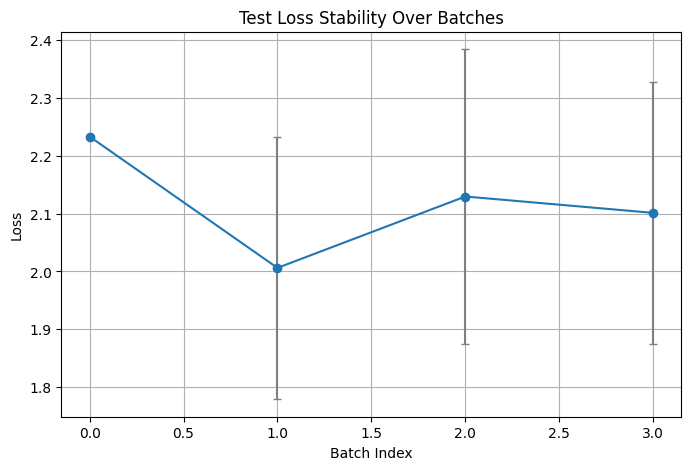

Evaluation Report:
              precision    recall  f1-score   support

       <PAD>     0.0000    0.0000    0.0000         0
       I-LOC     0.3674    0.4597    0.4084       211
      I-MISC     0.2500    0.4346    0.3174       191
       I-ORG     0.2948    0.4369    0.3520       309
       I-PER     0.2577    0.4310    0.3226       232
           O     0.9318    0.8331    0.8797      4902

    accuracy                         0.7697      5845
   macro avg     0.3503    0.4326    0.3800      5845
weighted avg     0.8287    0.7697    0.7943      5845



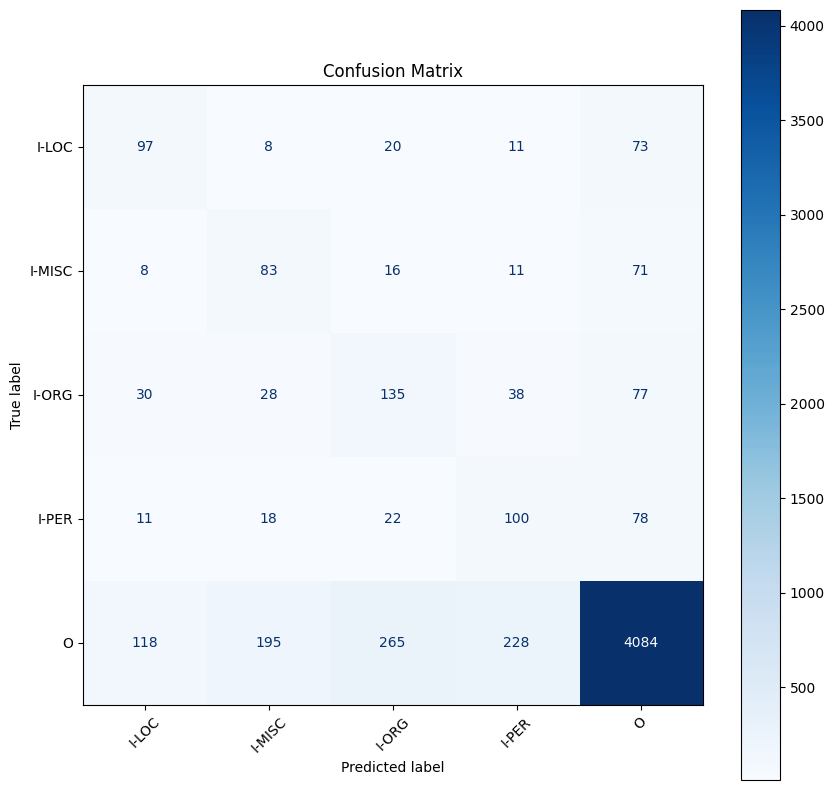

In [ ]:
# evaluate the results of the BiLSTM model and display the results
eval_results = evaluate_model(model, test_loader, label_indices, device)